In [1]:
import torch
import pandas as pd
import json
import transformer_ee.dataloader.string_conv as string_conv
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [2]:
mps_device = torch.device("mps")

In [3]:
df = pd.read_csv(
    "transformer_ee/data/dataset_rnne_dune_numu.csv.xz"
)

with open("transformer_ee/config/input.json", "r") as f:
    input_d = json.load(f)
df


,addr.event,addr.run,addr.subRun,event.calE,event.charge,event.nHits,mc.hadE,mc.isCC,mc.lepE,mc.lepPdg,...,particle.dir.x,particle.dir.y,particle.dir.z,particle.energy,particle.is_shower,particle.length,particle.nHit,particle.start.x,particle.start.y,particle.start.z
0,7,20000000.0,0,30203900.0,149993.0,511,1.371830,1,0.151595,13,...,"-0.318043,0.676179,-0.00776726,0.802108","0.297779,-0.552564,-0.24066,-0.582458","0.900098,0.487294,0.970578,-0.131775","1,0,0,1","0,1,1,0","113.596,59.5103,17.8954,14.9718","599,241,65,54","118.919,133.691,119.41,167.869","-180.876,-198.03,-182.039,-208.492","409.061,414.851,408.037,399.261"
1,8,20000000.0,0,62820800.0,311968.0,1084,2.080010,1,0.337277,13,...,"0.226116,-0.189044,0.571686,-0.513081,-0.70536...","0.215491,-0.27417,0.5332,-0.488068,-0.684719,-...","0.949966,0.942917,0.623597,0.706071,-0.183349,...","1,0,1,0,1,1","0,1,0,1,0,0","225.873,150.112,115.599,46.3016,93.2501,5.81189","1231,665,393,329,232,26","70.4171,61.6726,112.197,50.0037,70.3559,37.1269","-7.65268,-0.0106138,23.2165,-26.9206,-7.50411,...","354.128,381.957,518.058,381.104,353.234,382.549"
2,9,20000000.0,0,25809400.0,128170.0,708,0.325535,1,0.838949,13,...,"-0.26472,0.210488","0.133682,-0.151932","0.955014,-0.965718","1,1","0,0","208.052,102.736","1135,584","-3.94439,4.00233","213.008,208.172","168.486,139.59"
3,11,20000000.0,0,39996300.0,198621.0,979,1.004660,1,0.911412,13,...,"-0.0190656,-0.230444,0.0709952,-0.358985","0.635307,0.949337,0.835145,-0.439605","0.772024,0.21367,-0.545428,0.823333","1,0,0,1","0,1,1,0","381.467,42.3716,19.7011,5.09491","1914,241,66,31","96.8317,93.2549,96.8798,93.3869","-525.364,-498.272,-522.659,-499.672","365.236,368.705,365.255,366.042"
4,12,20000000.0,0,29356100.0,145782.0,487,0.869875,1,0.768649,13,...,"-0.638627,0.189804,0.269088","0.665284,0.40506,0.332641","0.386719,-0.894372,0.903848","1,0,1","0,1,0","290.078,17.9981,3.74647","853,68,41","198.62,200.258,199.332","-457.331,-459.092,-457.888","43.8627,40.6162,43.4711"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110569,87,20000000.0,0,48617500.0,241435.0,1228,1.772010,1,1.089150,13,...,"-0.499851,0.697227","0.0543951,0.262626","0.864402,0.667009","1,1","0,0","446.111,93.4168","2216,317","-10.0611,-9.80515","-83.2334,-83.1174","978.336,978.764"
110570,91,20000000.0,0,12323800.0,61199.9,191,0.887965,1,3.214130,13,...,"-0.411758,0.327938,0.880215","-0.885496,-0.558781,-0.229429","0.215294,-0.761722,-0.415432","0,0,0","1,1,1","54.6374,18.1909,4.65292","186,49,42","63.6696,61.243,65.4537","-170.045,-232.012,-170.445","1373.97,1348.4,1374.26"
110571,95,20000000.0,0,36140600.0,179474.0,731,1.508350,1,0.378792,13,...,"-0.660677,0.524907,-0.537467,-0.160205,-0.843349","0.175908,0.322841,0.0961814,0.574085,0.0698547","0.729769,0.787557,-0.837781,-0.80297,-0.532806","0,1,0,0,1","1,0,1,1,0","239.721,71.8002,31.6396,15.7967,5.85386","724,356,117,79,21","-56.7442,-45.1521,-119.578,-131.216,-45.5392","-168.446,-170.893,-152.828,-149.656,-170.933","470.174,460.22,486.933,491.935,459.689"
110572,98,20000000.0,0,38168600.0,189545.0,664,1.765120,1,0.312621,13,...,"0.151613,0.797928,0.00250241","0.538701,0.0201111,0.999589","0.828743,0.602417,-0.028564","0,1,1","1,0,0","253.215,75.9673,12.4347","1213,312,37","231.295,232.098,231.247","-305.174,-304.721,-306.302","1100.73,1101.16,1105.12"


In [4]:
for particle_feature in input_d["vector"]:
    df[particle_feature] = df[particle_feature].apply(string_conv.string_to_float_list)

In [5]:
class Pandas_NC_Dataset(Dataset):
    def __init__(self, dataframe, config: dict):
        self.df = dataframe
        self.len = len(dataframe)
        self.maxpronglen = config["max_num_prongs"]
        self.vectornames = config["vector"]
        self.scalarnames = config["scalar"]
        self.targetname = config["target"]

        # calculate mean and std for normalization
        self.stat_scalar = []
        for x in self.scalarnames:
            self.stat_scalar.append([df[x].mean(), df[x].std()])
        self.stat_scalar = torch.Tensor(self.stat_scalar).T
        self.stat_scalar = self.stat_scalar[:, None, :]

        self.stat_vector = []
        for x in self.vectornames:
            _tmp = []
            for y in df[x]:
                _tmp.extend(y)
            self.stat_vector.append([np.mean(_tmp), np.std(_tmp)])
        self.stat_vector = torch.Tensor(self.stat_vector).T
        self.stat_vector = self.stat_vector[:, None, :]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        _vectorsize = len(row[self.vectornames[0]])
        _vector = torch.Tensor(row[self.vectornames]).T
        _scalar = torch.Tensor(row[self.scalarnames]).T
        _vector = (_vector - self.stat_vector[0]) / self.stat_vector[1]
        _scalar = (_scalar - self.stat_scalar[0]) / self.stat_scalar[1]

        return (
            # pad the vector to maxpronglen
            F.pad(_vector, (0, 0, 0, self.maxpronglen - _vectorsize), "constant", 0),
            # return the scalar
            _scalar,
            # return src_key_padding_mask
            F.pad(
                torch.zeros(_vectorsize, dtype=torch.bool),
                (0, self.maxpronglen - _vectorsize),
                "constant",
                1,
            ),
            torch.Tensor(row[self.targetname]),
        )

    def __len__(self):
        return self.len


In [6]:
dataset = Pandas_NC_Dataset(df, input_d)

batch_size_train = 1024
batch_size_test = 1024


In [7]:
seed = 0
_indices = np.arange(len(df))
np.random.seed(seed)
np.random.shuffle(_indices)
test_size = 0.2
train_indicies = _indices[: int(len(_indices) * (1 - test_size))]
test_indicies = _indices[int(len(_indices) * (1 - test_size)) :]

In [8]:
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indicies)
test_dataset = Subset(dataset, test_indicies)

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)  

In [9]:
from transformer_ee.model.transformerEncoder_CC import Transformer_EE_v1
net=Transformer_EE_v1().to(mps_device)


In [10]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [11]:
loss_list = []
epochs = 100
error_list = []
lossfunc = nn.MSELoss()

for i in range(epochs):

    net.train()  # begin training

    for (batch_idx, batch) in enumerate(trainloader):
        vector_train_batch = batch[0].to(mps_device)
        scalar_train_batch = batch[1].to(mps_device)
        mask_train_batch = batch[2].to(mps_device)
        target_train_batch = batch[3].to(mps_device)

        Netout = net.forward(vector_train_batch, mask_train_batch)
        # This will call the forward function, usually it returns tensors.

        '''loss = torch.mean(
            torch.abs((Netout - target_train_batch) / target_train_batch)
        )'''  # regression loss
        loss = lossfunc(Netout, target_train_batch)

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 1 == 0:
            # print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.4f}".format(i, batch_idx, loss))


/var/folders/f_/6c826v810dx25pkgjg_810h00000gn/T/ipykernel_46797/1612017474.py:30: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3281.)
  _scalar = torch.Tensor(row[self.scalarnames]).T


Epoch: 0, batch: 0 Loss: 9.2344
Epoch: 0, batch: 1 Loss: 4.4312
Epoch: 0, batch: 2 Loss: 4.3433
Epoch: 0, batch: 3 Loss: 4.2003
Epoch: 0, batch: 4 Loss: 4.2274
Epoch: 0, batch: 5 Loss: 4.2406
Epoch: 0, batch: 6 Loss: 4.1517
Epoch: 0, batch: 7 Loss: 4.2398
Epoch: 0, batch: 8 Loss: 4.4355
Epoch: 0, batch: 9 Loss: 4.3317
Epoch: 0, batch: 10 Loss: 4.3568
Epoch: 0, batch: 11 Loss: 4.2761
Epoch: 0, batch: 12 Loss: 4.3032
Epoch: 0, batch: 13 Loss: 4.1587
Epoch: 0, batch: 14 Loss: 4.3795
Epoch: 0, batch: 15 Loss: 4.2330
Epoch: 0, batch: 16 Loss: 4.2666
Epoch: 0, batch: 17 Loss: 4.2250
Epoch: 0, batch: 18 Loss: 4.2200
Epoch: 0, batch: 19 Loss: 4.3225
Epoch: 0, batch: 20 Loss: 4.0795
Epoch: 0, batch: 21 Loss: 4.3272
Epoch: 0, batch: 22 Loss: 4.1311
Epoch: 0, batch: 23 Loss: 4.2956
Epoch: 0, batch: 24 Loss: 4.3554
Epoch: 0, batch: 25 Loss: 4.3277
Epoch: 0, batch: 26 Loss: 4.3489
Epoch: 0, batch: 27 Loss: 4.1208
Epoch: 0, batch: 28 Loss: 4.1960
Epoch: 0, batch: 29 Loss: 4.3052
Epoch: 0, batch: 30 

KeyboardInterrupt: 

In [ ]:
torch.save(net.state_dict(), "transformer_ee/model/CCtransformer_ee_v1.pt")


In [ ]:
from transformer_ee.model.transformerEncoder_CC import Transformer_EE_v3

net=Transformer_EE_v3().to(mps_device)
net.load_state_dict(torch.load("transformer_ee/model/CCtransformer_ee_v1.pt"))
net.eval()

mean resolution:  nan
std resolution:  nan


/opt/homebrew/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6679: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/homebrew/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6680: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

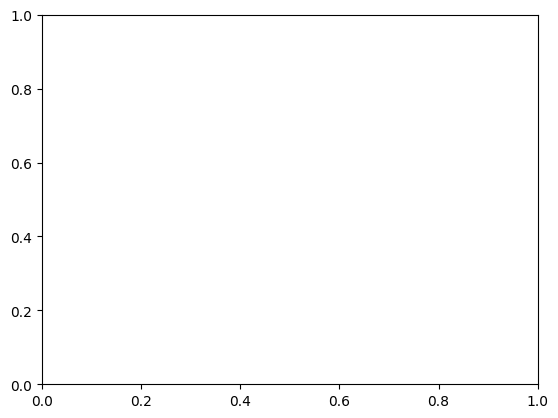

In [13]:
net.eval()
net.to(mps_device)
a, b, c, d=next(iter(testloader))
net.cpu()
e=net.forward(a, c) 
from matplotlib import pyplot as plt
numpyd=d[:, 0].cpu().detach().numpy()
numpye=e[:, 0].cpu().detach().numpy()
resolution=(numpye-numpyd)/numpyd
print("mean resolution: ", np.mean(resolution))
print("std resolution: ", np.std(resolution))
plt.hist((numpye-numpyd)/numpyd, bins=100)
plt.show()
net.to(mps_device)

In [ ]:
from matplotlib import pyplot as plt
plt.scatter(numpyd, numpye)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.show()

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df[["event.calE",
        "event.charge",
        "event.nHits",
        "mc.nuE"]], alpha = 0.2, figsize = (6, 6), diagonal = 'kde')
